This notebook uses the q_learning_lib.py to perform Q-learning on tic tac toe.

A variation of different hyperparameters are tried, against many different cases.

In [25]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import q_learning_lib as qlb
import json
import os

Assuming alpha = 0.1 and tau = e, lets record what happens in each of the 4 cases of training (optimal, non optimal, x, o)

In [26]:
NUMBER_OF_BATCHES = 500
BATCH_SIZE = 10
NUMBER_OF_GAMES = NUMBER_OF_BATCHES * BATCH_SIZE

In [27]:
def make_alpha(rate_val):
    """Function factorie for creating different alpha functions"""
    def alpha(turn):

        #return rate_val * (BATCH_SIZE * NUMBER_OF_BATCHES - turn) / (NUMBER_OF_BATCHES * BATCH_SIZE)
        #return 0.5 / (1 + rate_val * turn) 

        return 0.5 * np.exp(-rate_val * turn) #my new proposed fucntion

    return alpha

def make_tau(rate_val):
    """Function factorie for creating different tau functions"""
    def tau(turn):
        #return 1 + max_rate * (turn) / (NUMBER_OF_BATCHES * BATCH_SIZE) 
        #return 1 + (max_rate - 1) * ((turn/(NUMBER_OF_BATCHES * BATCH_SIZE))**3)
        return np.pow(10000, np.pow(turn/(NUMBER_OF_GAMES), rate_val )) #my new proposed function

    return tau


In [28]:

def record_params(results, filename):

    df = pd.DataFrame(results[::-1], columns=['o_win', 'draw', 'x_win'])

    # Save to CSV (index=False prevents it from adding a row-number column)
    df.to_csv(filename, index=False)

In [29]:
alpha_exponents = np.linspace(-4, -10, 10)
alpha_values = np.pow(10, alpha_exponents)
tau_exponents = np.linspace(-3, 3, 10 )
tau_values = np.pow(10, tau_exponents)
print(alpha_values)
print(tau_values)
print(tau_exponents)

[1.00000000e-04 2.15443469e-05 4.64158883e-06 1.00000000e-06
 2.15443469e-07 4.64158883e-08 1.00000000e-08 2.15443469e-09
 4.64158883e-10 1.00000000e-10]
[1.00000000e-03 4.64158883e-03 2.15443469e-02 1.00000000e-01
 4.64158883e-01 2.15443469e+00 1.00000000e+01 4.64158883e+01
 2.15443469e+02 1.00000000e+03]
[-3.         -2.33333333 -1.66666667 -1.         -0.33333333  0.33333333
  1.          1.66666667  2.33333333  3.        ]


In [30]:
def try_different_hyperparams(alpha_rates, tau_rates, player, strategy, folder=""):
    """this functions tries a variation of different hyperparameters
    results from every single iteration are saved in a .csv file
    how alpha params, tau values affect the final winrates is recorded in a pandas df and also saved to a file """
 
    df_list = [] #will be turned to a df later
    
    for a, alpha_rate in enumerate(alpha_rates): 
        for b, tau_rate in enumerate(tau_rates):

            #trains
            Q_Table_x_optimal, results = qlb.perform_training(player, strategy, NUMBER_OF_BATCHES, BATCH_SIZE, False, make_alpha(alpha_rate), make_tau(tau_rate))

            results = results/(BATCH_SIZE * 50)
        
            #records the resultsplayer_x_label='x', player_o_label='o', 
            filename = f"parameter_results/{player}_vs_{strategy}/_opponent_alpha_{alpha_rate}_tau_{tau_rate}.csv"
            record_params(results, filename)

            
            #records end winrates vs hyperparams
            o_winrate = np.mean(results[:, 0][-5:])
            drawrate = np.mean(results[:, 1][-5:])
            x_winrate = np.mean(results[:, 2][-5:])
            new_results = {'alpha_rate': alpha_rate, 'tau_rate': tau_rate, 'o_winrate': o_winrate, 'drawrate': drawrate, 'x_winrate': x_winrate}
            df_list.append(new_results)

            print(f"{player}_vs_{strategy}: {((a * 10 + b + 1)/(len(alpha_rates) * len(tau_values))) * 100:.2f}%")
            print(f"'alpha_rate' {alpha_rate}, 'tau_rate': {tau_rate}, 'o_winrate': {o_winrate:.3f}, 'drawrate': {drawrate:.3f}, 'x_winrate': {x_winrate:.3f}")

    df = pd.DataFrame(df_list) 
    df.to_csv(f"parameter_results/{player}_vs_{strategy}/hyperparams.csv", index=False)

In [31]:
#try_different_hyperparams(alpha_values, tau_values, 'x', 'perfect')
#try_different_hyperparams(alpha_values, tau_values, 'o', 'perfect')
#try_different_hyperparams(alpha_values, tau_values, 'x', 'random')
#try_different_hyperparams(alpha_values, tau_values, 'o', 'random')


In [32]:
df = pd.read_csv('parameter_results/x_vs_perfect/hyperparams.csv')

Text(0.5, 1.0, 'Max drawrate achieved 99.80%')

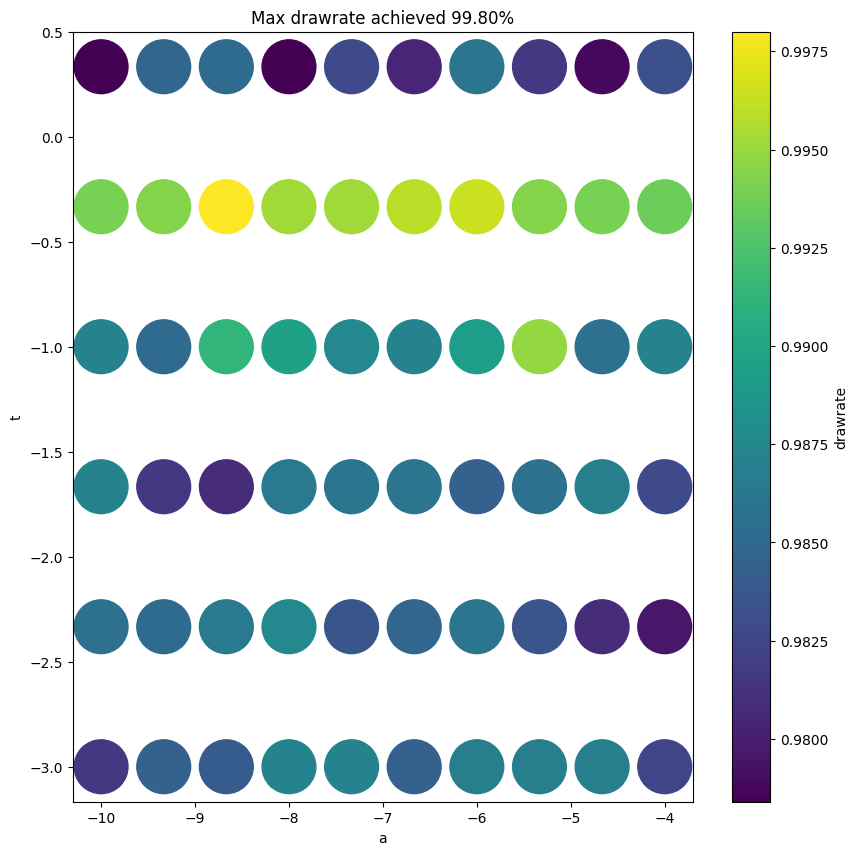

In [33]:
# 1. Create the figure and axis
fig, ax = plt.subplots(figsize=(10, 10))

mask = df[np.log10(df['tau_rate']) < 1]#[np.log10(df['alpha_rate']) <= -4][np.log10(df['tau_rate']) <= -2]

x = np.log10(mask['alpha_rate'])
y = np.log10(mask['tau_rate'])
z = mask['drawrate']

# 2. Capture the return value (the "mappable")
scatter = ax.scatter(x, y, c=z, s=1500, cmap='viridis') # cmap is optional but recommended

# 3. Pass the scatter object to the colorbar
fig.colorbar(scatter, ax=ax, label=z.name)
ax.set_xlabel('a')
ax.set_ylabel('t')
ax.set_title(f"Max {z.name} achieved {z.max() * 100 :.2f}%")

I have found good parameters for alpha rate and tau rate which should be implemented:

alpha_rate 10^-7

tau_rate = 10^-0.333


Now the goal is to create a matrix:

I will train 4 models on those parameters and record the results after playing 1000 games against each other using tau as the softmax

In [34]:
alpha = make_alpha(np.pow(10.0, -7))
tau = make_tau(np.pow(10.0, -1/3))

Q_Table_X_Perfect, results = qlb.perform_training('x', 'perfect', NUMBER_OF_BATCHES, BATCH_SIZE, False, alpha, tau)
print(results[-1, :])
Q_Table_X_Random, results = qlb.perform_training('x', 'random', NUMBER_OF_BATCHES, BATCH_SIZE, False, alpha, tau)
print(results[-1, :])
Q_Table_O_Perfect, results = qlb.perform_training('o', 'perfect', NUMBER_OF_BATCHES, BATCH_SIZE, False, alpha, tau)
print(results[-1, :])
Q_Table_O_Random, results = qlb.perform_training('o', 'random', NUMBER_OF_BATCHES, BATCH_SIZE, False, alpha, tau)
print(results[-1, :])

[  3 497   0]
[ 23  18 459]
[  0 499   1]
[360  57  83]


In [ ]:
for entry in Q_Table_X_Random:
    print(entry)
    print(Q_Table_X_Random[entry])

oxxxoxoox
[0. 0. 0. 0. 0. 0. 0. 0. 0.]
oxoxxxoox
[0. 0. 0. 0. 0. 0. 0. 0. 0.]
xxooxxxoo
[0. 0. 0. 0. 0. 0. 0. 0. 0.]
oxxxxooox
[0. 0. 0. 0. 0. 0. 0. 0. 0.]
xoxxooxxo
[0. 0. 0. 0. 0. 0. 0. 0. 0.]
xxxxoooox
[0. 0. 0. 0. 0. 0. 0. 0. 0.]
oxxxoooxx
[0. 0. 0. 0. 0. 0. 0. 0. 0.]
xoxooxoxx
[0. 0. 0. 0. 0. 0. 0. 0. 0.]
xxooxoxox
[0. 0. 0. 0. 0. 0. 0. 0. 0.]
ooxxxxxoo
[0. 0. 0. 0. 0. 0. 0. 0. 0.]
xooxxxoxo
[0. 0. 0. 0. 0. 0. 0. 0. 0.]
oxoxxooxx
[0. 0. 0. 0. 0. 0. 0. 0. 0.]
oxxoxxxoo
[0. 0. 0. 0. 0. 0. 0. 0. 0.]
ooxooxxxx
[0. 0. 0. 0. 0. 0. 0. 0. 0.]
ooxoxoxxx
[0. 0. 0. 0. 0. 0. 0. 0. 0.]
oxxxxooxo
[0. 0. 0. 0. 0. 0. 0. 0. 0.]
xoxoxxoxo
[0. 0. 0. 0. 0. 0. 0. 0. 0.]
ooxxoxoxx
[0. 0. 0. 0. 0. 0. 0. 0. 0.]
oxooxxxxo
[0. 0. 0. 0. 0. 0. 0. 0. 0.]
xoooxxxox
[0. 0. 0. 0. 0. 0. 0. 0. 0.]
xxxooxxoo
[0. 0. 0. 0. 0. 0. 0. 0. 0.]
xooxxxoox
[0. 0. 0. 0. 0. 0. 0. 0. 0.]
xooxxooxx
[0. 0. 0. 0. 0. 0. 0. 0. 0.]
xoxoxoxox
[0. 0. 0. 0. 0. 0. 0. 0. 0.]
xooooxxxx
[0. 0. 0. 0. 0. 0. 0. 0. 0.]
xxxooxoxo
[0. 0. 0. 0. 0.

In [36]:
number_of_games_in_the_match = 10000
results_x_perfect_vs_o_perfect = qlb.Q_Table_match(Q_Table_X_Perfect, Q_Table_O_Perfect, number_of_games_in_the_match, 'perfect', 10)
results_x_perfect_vs_o_random = qlb.Q_Table_match(Q_Table_X_Perfect, Q_Table_O_Random, number_of_games_in_the_match, 'softmax', 10)
results_x_random_vs_o_perfect = qlb.Q_Table_match(Q_Table_X_Random, Q_Table_O_Perfect, number_of_games_in_the_match, 'softmax', 10)
results_x_random_vs_o_random = qlb.Q_Table_match(Q_Table_X_Random, Q_Table_O_Random, number_of_games_in_the_match, 'softmax', 10)
results_fully_random_game = qlb.Q_Table_match(Q_Table_X_Perfect, Q_Table_O_Perfect, number_of_games_in_the_match, 'softmax', 1)

___
___
___
x__
___
___
o__
___
___


KeyError: 'o________'

In [ ]:
print(results_x_perfect_vs_o_perfect )
print(results_x_perfect_vs_o_random )
print(results_x_random_vs_o_perfect )
print(results_x_random_vs_o_random )
print(results_fully_random_game)

[1407. 5895. 2698.]
[1396. 5959. 2645.]
[ 726. 8199. 1075.]
[ 677. 8260. 1063.]
[1150. 5939. 2911.]
